In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [66]:
#get energy function for 2D ising
def Energy(lat,J=1):
    
    def E_along(row,J=1):
        return sum([-J*row[(i+1)]*row[i] for i in range(0,len(row)-1)])
    
    E_lat = sum([E_along(row) for row in lat])
    E_lat_T = sum([E_along(row) for row in lat.T])
    return E_lat + E_lat_T

#figure out energy spectrum
def calc_E_spectrum(n):
    n_squared = n**2
    #create flat lattice and square lattice for minimum energy
    min_lat_flat = np.array([1]*n_squared)
    min_lat = min_lat_flat.reshape((n,n))
    Emin = float(Energy(min_lat))
    
    #Max energy is every other spin is flipped
    min_lat_flat[::2] = -1
    max_lat = min_lat_flat.reshape((n,n))
    if n%2 == 0:
        max_lat[::2] = max_lat[::2]*-1
    Emax = float(Energy(max_lat))

    #flip a spin to see how it is discritized
    flip_lat = np.array([-1] + [1]*(n_squared - 1)).reshape((n,n))
    Eflip = Energy(flip_lat)
    
    #calculate the change in energy
    dE = (Eflip-Emin)/2
    
    #generate the spectrum
    print(f'Emax = {Emax}, Emin = {Emin}, dE = {dE}')
    E_spectrum = np.arange(Emin,Emax+dE,dE)
    return np.delete(E_spectrum, [1,-2])


In [81]:
N = 10
N_squared = N**2
lattice = (2*np.random.randint(2,size=(1,N_squared))[0]-1).reshape((N,N))

E_spectrum = calc_E_spectrum(N)
print(E_spectrum)
E_curr = Energy(lattice)

#density of states has form of energy spectrum!
log_g = np.zeros_like(E_spectrum) #would be all 0, starting g at 1

#initialize histogram -> what will be judged if flat
histogram = np.zeros_like(E_spectrum)

#modification factor
f = 1 #ln(e) = 1
tot = 0
while f>10**-8:
    #chooose random energy
    prop_bits = (np.random.randint(0,N), np.random.randint(0,N))
    lattice[prop_bits] = lattice[prop_bits]*-1
    E_proposed = Energy(lattice)
    
    #where is the energy value for the current and proposed
    ind_E_curr = np.where(E_spectrum==E_curr)[0][0]
    ind_E_proposed = np.where(E_spectrum==E_proposed)[0][0]
    
    #calculate the density of states
    g_curr = log_g[ind_E_curr]
    g_proposed = log_g[ind_E_proposed]
    
    #calc prob of acceptance
    prob_acceptance = np.exp(g_curr - g_proposed) #g_curr/g_proposed
    r = np.random.uniform(0,1)
    if r < np.minimum(1,prob_acceptance):
        E_curr = E_proposed
        ind_E_curr = ind_E_proposed
        
    else:
        #reject reflip spin
        lattice[prop_bits] = lattice[prop_bits]*-1
    
    histogram[ind_E_curr] += 1
    log_g[ind_E_curr] += f #add f because working w natural log, log(g*f) = log(g)+log(f)
    tot+=1
    if np.min(histogram) >= np.mean(histogram)*0.2:
        tot+=sum(histogram)
        print('success', tot)
        histogram = np.zeros_like(E_spectrum)
        f *= 0.5

Emax = 180.0, Emin = -180.0, dE = 2.0
[-180. -176. -174. -172. -170. -168. -166. -164. -162. -160. -158. -156.
 -154. -152. -150. -148. -146. -144. -142. -140. -138. -136. -134. -132.
 -130. -128. -126. -124. -122. -120. -118. -116. -114. -112. -110. -108.
 -106. -104. -102. -100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.  -84.
  -82.  -80.  -78.  -76.  -74.  -72.  -70.  -68.  -66.  -64.  -62.  -60.
  -58.  -56.  -54.  -52.  -50.  -48.  -46.  -44.  -42.  -40.  -38.  -36.
  -34.  -32.  -30.  -28.  -26.  -24.  -22.  -20.  -18.  -16.  -14.  -12.
  -10.   -8.   -6.   -4.   -2.    0.    2.    4.    6.    8.   10.   12.
   14.   16.   18.   20.   22.   24.   26.   28.   30.   32.   34.   36.
   38.   40.   42.   44.   46.   48.   50.   52.   54.   56.   58.   60.
   62.   64.   66.   68.   70.   72.   74.   76.   78.   80.   82.   84.
   86.   88.   90.   92.   94.   96.   98.  100.  102.  104.  106.  108.
  110.  112.  114.  116.  118.  120.  122.  124.  126.  128.  130.  132.
  134.  136. 

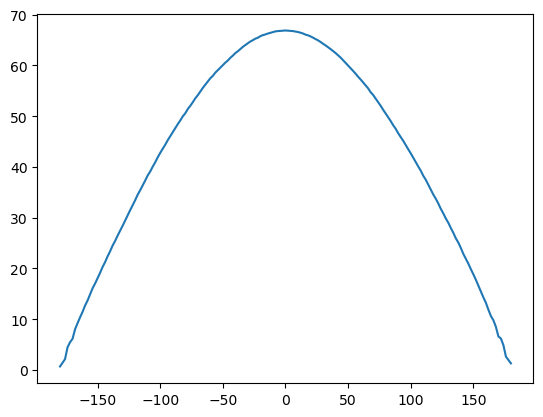

In [82]:
plt.plot(E_spectrum,log_g-log_g[0]+np.log(2))